# DeepFake: Face Swapping using AutoEncoders

+ This notebook leverages autoencoders to perform face swapping
+ We leverage datasets prepared using ```data_prep.ipynb``` notebook
+ This setup works by training two autoencoders, one for each personality
+ The autoencoders have a common encoder but separate decoders
+ We make use of blending techniques to finally patch the swapped faces

## Load Required Libraries

In [2]:
from deepfake_utils import Encoder, Decoder
from data_utils import get_image_paths, minibatchAB

In [13]:
import time
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [4]:
ENCODER_DIM = 1024
IMAGE_SHAPE = (64, 64, 3)

## Instantiate Autoencoders

In [5]:
encoder = Encoder(IMAGE_SHAPE,ENCODER_DIM)
decoder_A = Decoder()
decoder_B = Decoder()

In [6]:
optimizer = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999) #orig adam 5e-5
x = Input(shape=IMAGE_SHAPE)

autoencoder_A = Model(x, decoder_A(encoder(x)))
autoencoder_B = Model(x, decoder_B(encoder(x)))

autoencoder_A.compile(optimizer=optimizer, loss='mean_absolute_error')
autoencoder_B.compile(optimizer=optimizer, loss='mean_absolute_error')

In [7]:
print(encoder.summary())
print(autoencoder_A.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       9728      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         3277312   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 512)        

## Define Utility Methods

In [31]:
def train_one_step(iter,batch_genA,batch_genB,autoencoder_A,autoencoder_B):
    epoch, warped_A, target_A = next(batch_genA)
    epoch, warped_B, target_B = next(batch_genB)
    loss_A = autoencoder_A.train_on_batch(warped_A, target_A)

    loss_B = autoencoder_B.train_on_batch(warped_B, target_B)

    print("[#{0:5d}] loss_A: {1:.5f}, loss_B: {2:.5f}".format(iter, loss_A, loss_B))

In [9]:
def save_weights(model_dir,encoder,decoder_A,decoder_B):
    encoder.save_weights(model_dir+'/encoder.h5')
    decoder_A.save_weights(model_dir+'/decoder_A.h5')
    decoder_B.save_weights(model_dir+'/decoder_B.h5')
    print('saved model weights')

In [ ]:
!unzip nicolas_face.zip

In [ ]:
!unzip trump_face.zip

## Train the Autoencoders

In [33]:
ctr = 9000
batchsize = 64
save_interval=100
model_dir = "models"

fn_imgA = get_image_paths('nicolas_face')
fn_imgB = get_image_paths('trump_face')

batch_genA = minibatchAB(fn_imgA, batchsize)
batch_genB = minibatchAB(fn_imgB, batchsize)
for epoch in range(0, ctr):
    save_iteration = epoch % save_interval == 0

    train_one_step(epoch,batch_genA,batch_genB,autoencoder_A,autoencoder_B)

    if save_iteration:
        print("{}/{}".format(epoch,ctr))
        save_weights('models',encoder,decoder_A,decoder_B)

Streaming output truncated to the last 5000 lines.
[#  492] loss_A: 0.06667, loss_B: 0.05898
[#  493] loss_A: 0.06330, loss_B: 0.06273
[#  494] loss_A: 0.05797, loss_B: 0.05357
[#  495] loss_A: 0.06104, loss_B: 0.05726
[#  496] loss_A: 0.06374, loss_B: 0.05869
[#  497] loss_A: 0.05697, loss_B: 0.05539
[#  498] loss_A: 0.06187, loss_B: 0.05630
[#  499] loss_A: 0.05863, loss_B: 0.05762
[#  500] loss_A: 0.05765, loss_B: 0.05880
500/9000
saved model weights
[#  501] loss_A: 0.06422, loss_B: 0.05451
[#  502] loss_A: 0.06280, loss_B: 0.05957
[#  503] loss_A: 0.05964, loss_B: 0.05962
[#  504] loss_A: 0.06393, loss_B: 0.05710
[#  505] loss_A: 0.05931, loss_B: 0.05939
[#  506] loss_A: 0.05996, loss_B: 0.05701
[#  507] loss_A: 0.05905, loss_B: 0.05749
[#  508] loss_A: 0.06076, loss_B: 0.05953
[#  509] loss_A: 0.06548, loss_B: 0.05787
[#  510] loss_A: 0.06339, loss_B: 0.05957
[#  511] loss_A: 0.06501, loss_B: 0.05547
[#  512] loss_A: 0.06133, loss_B: 0.05593
[#  513] loss_A: 0.05903, loss_B: 0.05

KeyboardInterrupt: ignored

## Inference

In [77]:
from face_utils import Convert
from face_utils import FaceFilter
from face_utils import Extract
from face_utils import DetectedFace

import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import dlib
import face_recognition
import face_recognition_models

## Set the Parameters

In [52]:
conv_name = "Masked"
swap_model= False
blur_size=2
seamless_clone=False
mask_type="facehullandrect"
erosion_kernel_size=None
smooth_mask=True
avg_color_adjust=True
filter_image="trump_ref.png"

#DONT MODIFY 
IMAGE_SHAPE = (64, 64, 3)
ENCODER_DIM = 1024
encoderH5 = 'models/encoder.h5'
decoder_AH5 = 'models/decoder_A.h5'
decoder_BH5 = 'models/decoder_B.h5'

## Define Utility Functions

In [68]:
def convert(converter, item,output_dir):
    try:
        (filename, image, faces) = item
        image1 = None
        for idx, face in faces:
            image1 = converter.patch_image(image, face)
        if np.any(image1):
            output_file = output_dir+"/"+str(filename).split("/")[-1]
            cv2.imwrite(str(output_file), image1)
    except Exception as e:
        print('Failed to convert image: {}. Reason: {}'.format(filename, e))

In [69]:
def model_swapper(swap,autoencoder_A,autoencoder_B):
    autoencoder = autoencoder_B if not swap else autoencoder_A 
    return lambda img: autoencoder.predict(img)

In [70]:
def _css_to_rect(css):
    return dlib.rectangle(css[3], css[0], css[1], css[2])
    
def _raw_face_landmarks(face_image, face_locations):
    face_locations = [_css_to_rect(face_location) for face_location in face_locations]
    return [pose_predictor(face_image, face_location) for face_location in face_locations]

def detect_faces(frame):
    face_locations = face_recognition.face_locations(frame)
    landmarks = _raw_face_landmarks(frame, face_locations)

    for ((y, right, bottom, x), landmarks) in zip(face_locations, landmarks):
        yield DetectedFace(frame[y: bottom, x: right], 
                           x, right - x, y, bottom - y, landmarks)

In [71]:
def get_faces(reference_image,image,extractor,debug=False):
    faces_count = 0
    facefilter = FaceFilter(reference_image)
    for face in detect_faces(image):
        if not facefilter.check(face):
            print('Skipping not recognized face!')
            continue
        resized_image = extractor.extract(image, face, 256)
        if debug:
          imgplot = plt.imshow(cv2.cvtColor(resized_image , cv2.COLOR_BGR2RGB ))
          plt.show()

        yield faces_count, face
        faces_count +=1

In [72]:
def get_list_images_faces(input_dir,reference_image,extractor):
    input_list = get_image_paths(input_dir)
    listFile=[]
    for filename in tqdm(input_list):
        listFile.append(filename)
    for filename in listFile:
        image = cv2.imread(filename)
        yield filename, image, get_faces(reference_image,image,extractor,debug=True)

## Let the Swapping Begin

In [73]:
predictor_68_point_model = face_recognition_models.pose_predictor_model_location()
pose_predictor = dlib.shape_predictor(predictor_68_point_model)

In [74]:
extractor = Extract()

In [79]:
faceswap_converter = Convert(model_swapper(False,autoencoder_A,autoencoder_B),
    blur_size=blur_size,
    seamless_clone=seamless_clone,
    mask_type=mask_type,
    erosion_kernel_size=erosion_kernel_size,
    smooth_mask=smooth_mask,
    avg_color_adjust=avg_color_adjust
)

list_faces=get_list_images_faces('nicolas_face','nicolas_ref.png',extractor)

100%|██████████| 582/582 [00:00<00:00, 689766.86it/s]


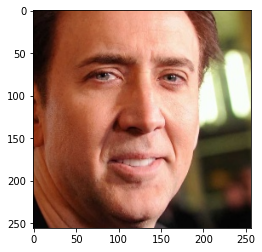

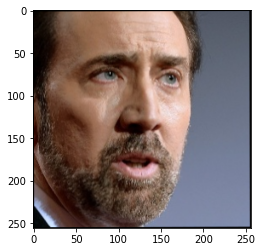

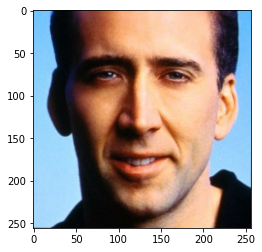

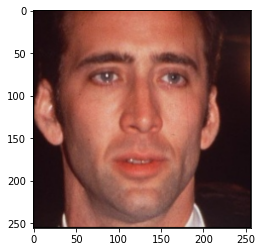

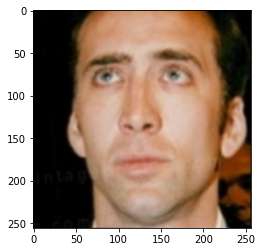

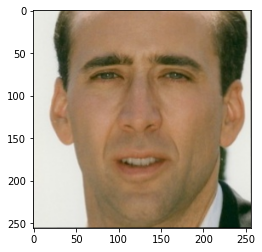

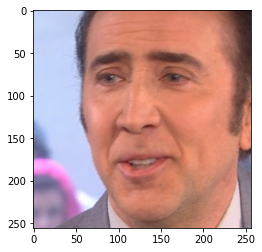

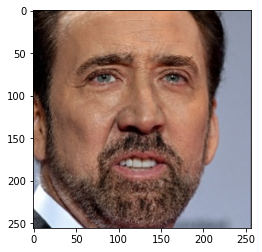

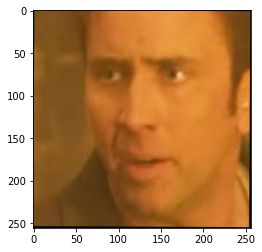

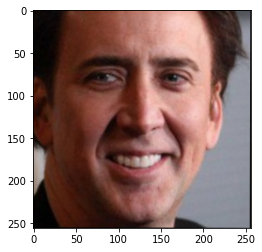

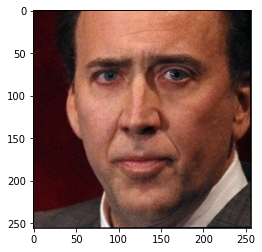

No faces found in the image!
Skipping not recognized face!


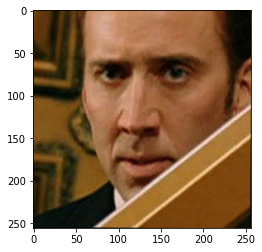

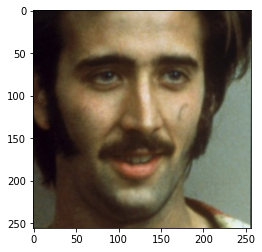

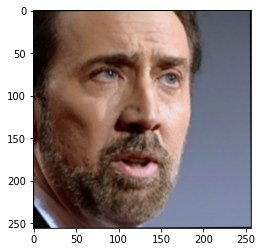

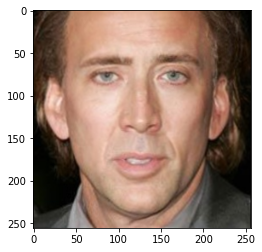

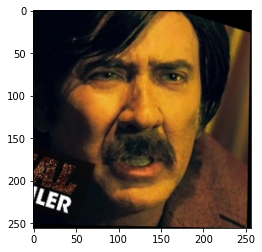

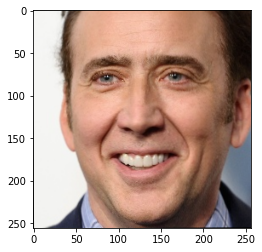

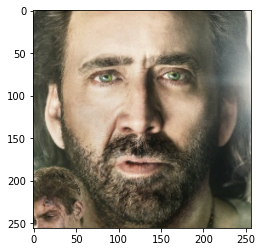

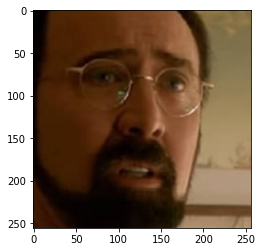

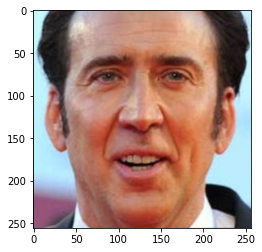

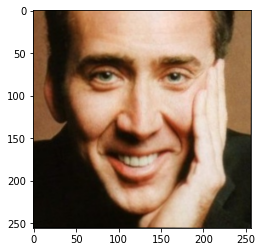

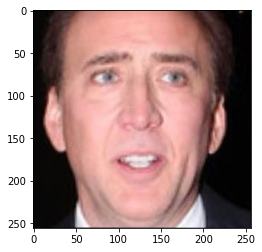

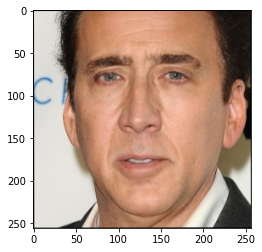

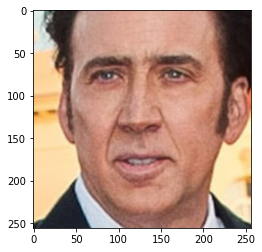

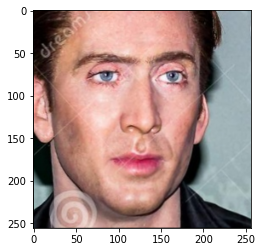

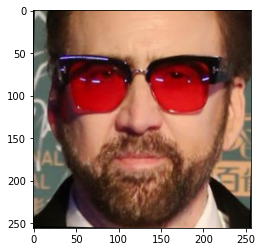

KeyboardInterrupt: ignored

In [80]:
for item in list_faces:
    convert(faceswap_converter, item,'face_swaps')